In [50]:
import os
import json
import numpy as np
from sklearn import metrics

import evaluate
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from datasets import Dataset

ImportError: cannot import name 'ConfusionMatrixDisplay' from 'sklearn' (/opt/conda/lib/python3.13/site-packages/sklearn/__init__.py)

In [2]:
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "TRUE"

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [4]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [5]:
with open("./data/project-4-at-2025-08-29-12-33-3986b847.json") as fd:
    data = json.loads(fd.read())

In [41]:
label2id = {
    "Roadblock": 0,
    "Subsidy": 1,
    "Other": 2,
}

id2label = {
    0: "Roadblock",
    1: "Subsidy",
    2: "Other",
}

In [7]:
data_formatted = [{"text": task["data"]["text"], "label": label2id[task["annotations"][0]["result"][0]["value"]["choices"][0]]} for task in data]

In [8]:
for label_id in id2label:
    n = len([task for task in data_formatted if task["label"] == label_id])
    print(f"{label_id}: {n}")

0: 696
1: 50
2: 429


In [9]:
dataset = Dataset.from_list(data_formatted)
dataset = dataset.class_encode_column("label")
dataset

Stringifying the column:   0%|          | 0/1175 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1175 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 1175
})

In [10]:
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1057
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 118
    })
})

In [11]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
accuracy = evaluate.load("accuracy")

In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
    output_dir="uc1-uc2-model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.236106,0.906780
2,No log,0.181411,0.915254


TrainOutput(global_step=68, training_loss=0.13032997355741613, metrics={'train_runtime': 29.027, 'train_samples_per_second': 72.829, 'train_steps_per_second': 2.343, 'total_flos': 279850908253266.0, 'train_loss': 0.13032997355741613, 'epoch': 2.0})

In [59]:
y_preds = []
y_trues = []
classifier = pipeline("text-classification", tokenizer=tokenizer, model=model)
for val_task in dataset["test"]:
    y_preds.append(label2id[classifier(val_task["text"][:512])[0]["label"]])
    y_trues.append(val_task["label"])

Device set to use cuda:0


In [60]:
y_trues

[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2]

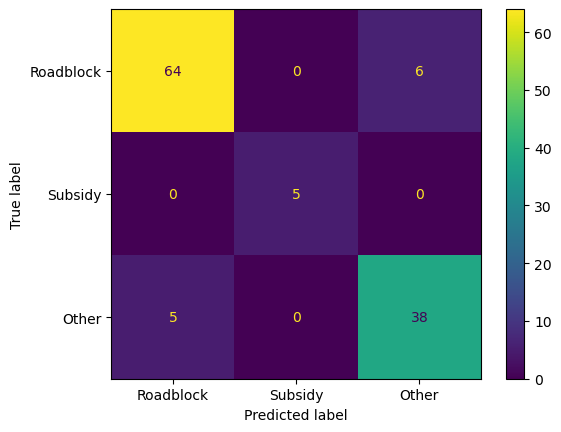

In [63]:
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds)
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=label2id.keys()).plot()